# SETD2
SETD2 is the primary methyltransferase catalyzing H3K36 trimethylation (H3K36me3)

In [3]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.5.1.dev0


### SETD2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SETD2.

In [1]:
gene_symbol = 'SETD2'
mane_tx_id = 'NM_014159.7'
mane_protein_id = 'NP_054878.5' # histone-lysine N-methyltransferase SETD2 isoform 1 [Homo sapiens]

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 29/29 [00:26<00:00,  1.07individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Delayed speech and language development,HP:0000750,14
Hypertelorism,HP:0000316,11
Highly arched eyebrow,HP:0002553,11
Macrocephaly,HP:0000256,10
Broad nasal tip,HP:0000455,10
Severe global developmental delay,HP:0011344,9
Midface retrusion,HP:0011800,9
Wide nasal bridge,HP:0000431,9
Low hanging columella,HP:0009765,9
Feeding difficulties,HP:0011968,9


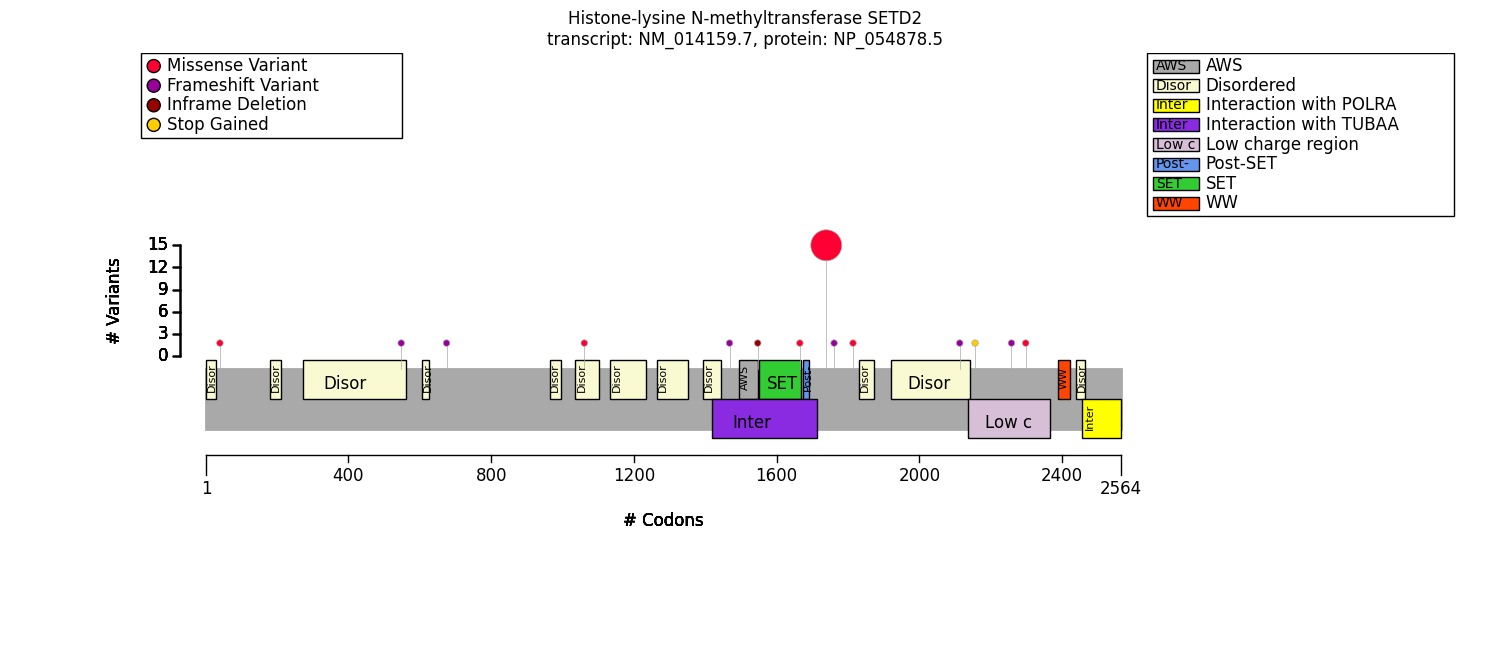

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
"""
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)
"""

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

# Strategy

In [7]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    missing_implies_excluded=False,
    min_n_of_patients_with_term=2,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
     term_frequency_threshold=0.2,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

In [8]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

pr1740w = VariantPredicates.variant_key(key="3_47088172_47088172_G_A") # 	c.5218C>T	p.Arg1740Trp	

p_pr1740w_predicate = monoallelic_predicate(a_predicate=pr1740w, b_predicate=~ pr1740w, names=("p.Met1?", "Other"))
p_pr1740w_predicate.display_question()


'Allele group: p.Met1?, Other'

In [10]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=p_pr1740w_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF03,Skipping term because of a child term with the same individual counts,7
HMF05,Skipping term because one genotype had zero observations,35
HMF08,Skipping general term,88
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.25,226


In [11]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       p.Met1?          Other  \
                                                     Count Percent  Count   
Seizure [HP:0001250]                                   7/7    100%    2/3   
Delayed speech and language development [HP:000...     4/4    100%  12/12   
Neurodevelopmental delay [HP:0012758]                  9/9    100%  14/14   
Neurodevelopmental abnormality [HP:0012759]            9/9    100%  15/15   
Abnormal communication [HP:0034434]                    4/4    100%  12/12   
Abnormality of skull size [HP:0000240]                 1/1    100%  10/10   
Abnormal axial skeleton morphology [HP:0009121]      10/10    100%  12/12   
Motor delay [HP:0001270]                               6/6    100%    8/8   
Recurrent maladaptive behavior [HP:5200241]            1/1    100%    7/7   
Atypical behavior [HP:0000708]                         2/2    100%  11/11   
Abnormal muscle tone [HP:0003808]                      3/3    100%    5/5   
Abnormal appendicular skeleton morphology [HP:0...     8/8    100%    1/1   
Broad nasal tip [HP:0000455]                           9/9    100%    1/1   
Abnormal external nose morphology [HP:0010938]         9/9    100%    1/1   
Abnormal nasal morphology [HP:0005105]                 9/9    100%    1/1   
Abnormality of the palpebral fissures [HP:0008050]     9/9    100%    1/1   
Abnormal ocular adnexa morphology [HP:0030669]       11/11    100%    2/2   
Abnormal digit morphology [HP:0011297]                 7/7    100%    1/1   
Abdominal symptom [HP:0011458]                       10/10    100%    1/1   
Global developmental delay [HP:0001263]                9/9    100%    1/1   
Abnormal eyebrow morphology [HP:0000534]             11/11    100%    1/1   

Allele group                                                                   \
                                                   Percent Corrected p values   
Seizure [HP:0001250]                                   67%                1.0   
Delayed speech and language development [HP:000...    100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Abnormality of skull size [HP:0000240]                100%                1.0   
Abnormal axial skeleton morphology [HP:0009121]       100%                1.0   
Motor delay [HP:0001270]                              100%                1.0   
Recurrent maladaptive behavior [HP:5200241]           100%                1.0   
Atypical behavior [HP:0000708]                        100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Abnormal appendicular skeleton morphology [HP:0...    100%                1.0   
Broad nasal tip [HP:0000455]                          100%                1.0   
Abnormal external nose morphology [HP:0010938]        100%                1.0   
Abnormal nasal morphology [HP:0005105]                100%                1.0   
Abnormality of the palpebral fissures [HP:0008050]    100%                1.0   
Abnormal ocular adnexa morphology [HP:0030669]        100%                1.0   
Abnormal digit morphology [HP:0011297]                100%                1.0   
Abdominal symptom [HP:0011458]                        100%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Abnormal eyebrow morphology [HP:0000534]              100%                1.0   

Allele group                                                 
                                                   p values  
Seizure [HP:0001250]                                    0.3  
Delayed speech and language development [HP:000...      1.0  
Neurodevelopmental delay [HP:0012758]                   1.0  
Neurodevelopmental abnormality [HP:0012759]           